# Mini Project 4

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

In the lectures we explored how to delta hedge sold call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant.

For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. You are also encouraged to explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy. 

Below is some code you can customize that simulates a stock path whose $\sigma$ is not constant.

You are encouraged to use a different model for sigma then the one provided. You can use stock paths simulated by Heston model? You could use a GARCH model for volatility. The choice is yours and you can do your own research to choose how to model a stock movement. 

In [24]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [25]:
def stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps):
    '''
    Generation of custom stock paths following Geometeric Brownian motion,
    but log-returns do not have constant volatility.
    
    Each step of the log-returns, there is a 
    1) 50% the volatility is .2
    2) 30% chance the volatility is .3
    3) 20% chance the volatility is .45
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    
    Returns:
    
    Simuatled stock paths
    '''
    
    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
    
    #Custom sigma that is not constant
    sigma = np.random.choice([.2,.3,.45], p = [.5, .3, .2], size = (n_paths, n_steps))
    
    #Time increment between each step
    dt = t/n_steps
    
    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    
    #paths
    paths = S0*np.exp(log_returns)
    
    
    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)
    
    
    return paths
    
    

We will be doing Heston model paths. This will give us a reasonable array of sigmas to apply to the above model. I will be using a timeframe of 63 days (one quarter of a year) to keep the graphs readable, and I will do 7 simulations at once.

In [66]:
def heston_path_sim_vonly(S0, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims=n_paths, mu=0, return_vol=False):
    """
    This is a heston model but returns only the volatilities. That is all we need.
    """
    dt = t / n_steps
    N1 = np.random.normal(0, 1, size=(n_sims, n_steps))
    N2 = np.random.normal(0, 1, size=(n_sims, n_steps))
    Y = rho * N1 + np.sqrt(1 - rho**2) * N2

    paths = np.zeros((n_sims, n_steps + 1))
    vols = np.zeros((n_sims, n_steps + 1))
    paths[:, 0] = S0
    vols[:, 0] = v0

    for i in range(n_steps):
        vols[:, i + 1] = np.abs(vols[:, i] + kappa * (theta - vols[:, i]) * dt +
                                xi * np.sqrt(np.maximum(vols[:, i], 0) * dt) * N1[:, i])
        paths[:, i + 1] = paths[:, i] * np.exp((mu + r - 0.5 * vols[:, i]) * dt +
                                               np.sqrt(np.maximum(vols[:, i], 0) * dt) * Y[:, i])
    
    return vols if return_vol else 0

In [67]:
#Here are some reasonable values. We will use the calculated volatility of the Heston model to vary sigma and perhaps come up with some more accurate
#stock paths.

S0 = 100
t = 1
r = 0.039
mu = 0.275
v0 = 0.08
kappa = 3
theta = 0.1
xi = .5
rho = -.65
n_paths = 7
n_steps = 63



We now use these Heston volatilities to create thirteen simulated paths. However, instead of the standard formula
$$S_t = S_0e^{\left(r -\frac{\sigma^2}{2} \right)t + \sigma\sqrt{t}\mathcal{N}(0,1)}.$$
we customize this for the various sigmas. Fortunately, all we need is the sum of squares of sigmas, so we can create a helper function assisting with that.

$$S_t = S_0 e^{\left(rt - \frac{t}{2n}\sum_{i=0}^{n-1} \sigma_i^2\right) + \sqrt{\frac{t}{n}\sum_{i=0}^{n-1} \sigma_i^2}\mathcal{N}(0,1)}.$$
where $n$ is the total number of steps. It helps that volatility is equal to $\sigma^2$.

In [50]:
def stock_path_custom_sigma_owen(S0, t, r, mu, n_paths, n_steps, v0 = 0.08, kappa=3, theta=0.1, xi=.5, rho=-.65):


    

    h = heston_path_sim_vonly(S0, v0, r, t, n_steps-1, kappa, theta, xi, rho, n_sims=n_paths, mu=0, return_vol=True)

    #print(h)

    SOSigmas=0.5*t/n_steps*(h).cumsum(axis=1)
    SOSP = np.sqrt(2*SOSigmas)
    '''
    Generation of custom stock paths following Geometeric Brownian motion,
    but log-returns do not have constant volatility.
    
    Each step of the log-returns, there is a 
    1) 50% the volatility is .2
    2) 30% chance the volatility is .3
    3) 20% chance the volatility is .45
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    
    Returns:
    
    Simuatled stock paths
    '''
    
    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
    
    
    
    #Time increment between each step
    dt = t/n_steps
    
   
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(r*dt*np.ones((n_paths,n_steps)),axis=1) - SOSigmas + SOSP*noise
    #print(log_returns)
    
    #paths
    paths = S0*np.exp(log_returns)
    
    
    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1) 
    
    
    return paths

In the above code sample, we first find the Heston volatilities, sum the squares and scale them (SOSigmas) and take the square root (SOSP). This gives a formula for the log-returns.

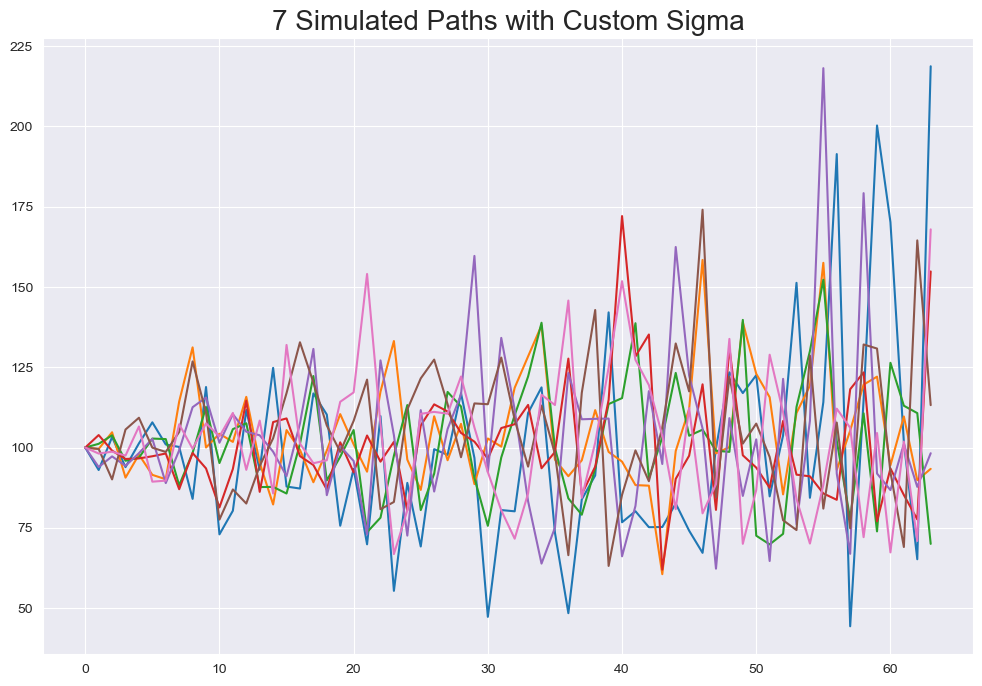

In [68]:
#Now we plot them. This is the default.
simulated_paths = stock_path_custom_sigma_owen(S0, t, r, mu, n_paths, n_steps, v0 = 0.08, kappa=3, theta=0.1, xi=.5, rho=-.65)


plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)


plt.show()

This is what I like to call moderate chaos. This seems to provide a remarkably good repreesentation of an unusually volatile stock. Let us modify this by altering a few of the paramaters. First we decrease $v_0$.

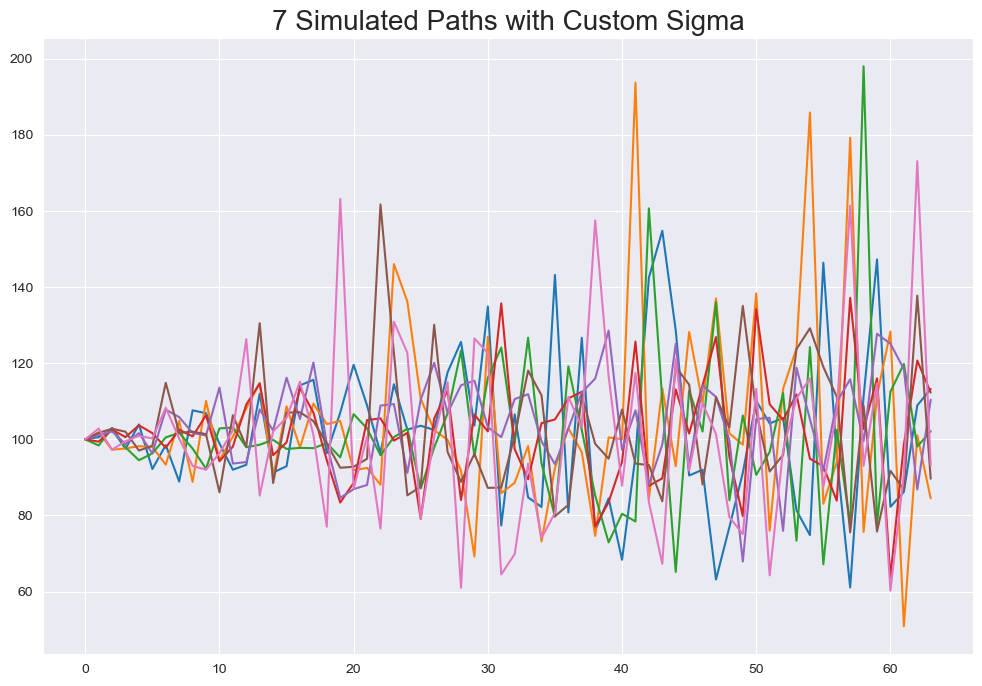

In [69]:
#Variation 1: sharp decrease in initial volatility
simulated_paths = stock_path_custom_sigma_owen(S0, t, r, mu, n_paths, n_steps, v0 = 0.02, kappa=3, theta=0.1, xi=.5, rho=-.65)


plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)


plt.show()

Not a lot changes, though there are less sharp movements.

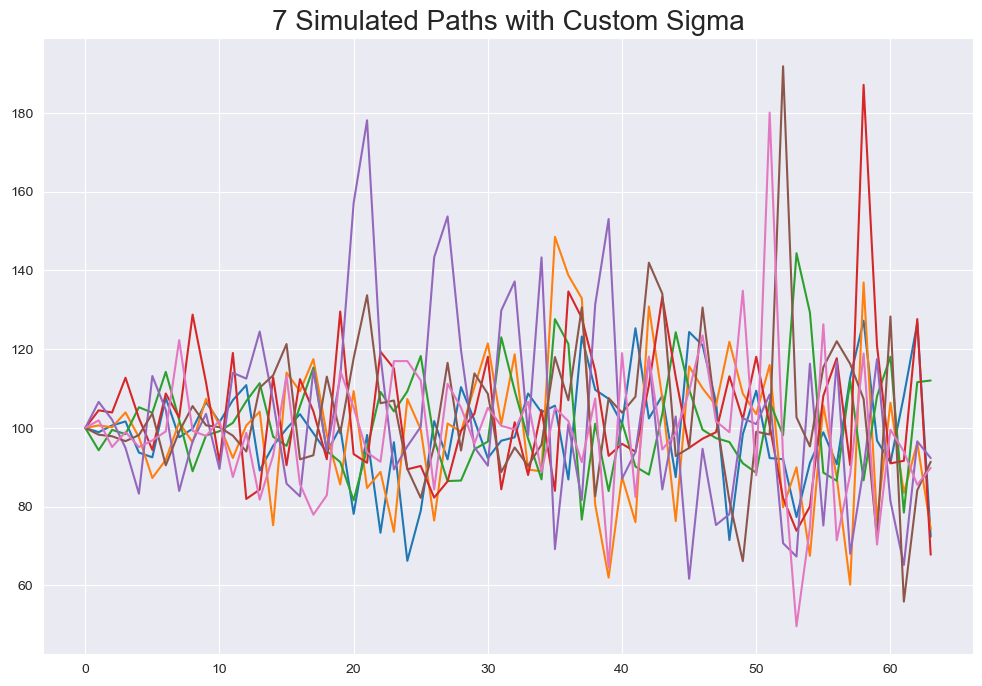

In [70]:
#Variation 2: decrease kappa for less reversion to the mean
simulated_paths = stock_path_custom_sigma_owen(S0, t, r, mu, n_paths, n_steps, v0 = 0.08, kappa=1, theta=0.1, xi=.5, rho=-.65)


plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)


plt.show()

The purple stock shoots upward many times, it's not regressing to the mean.

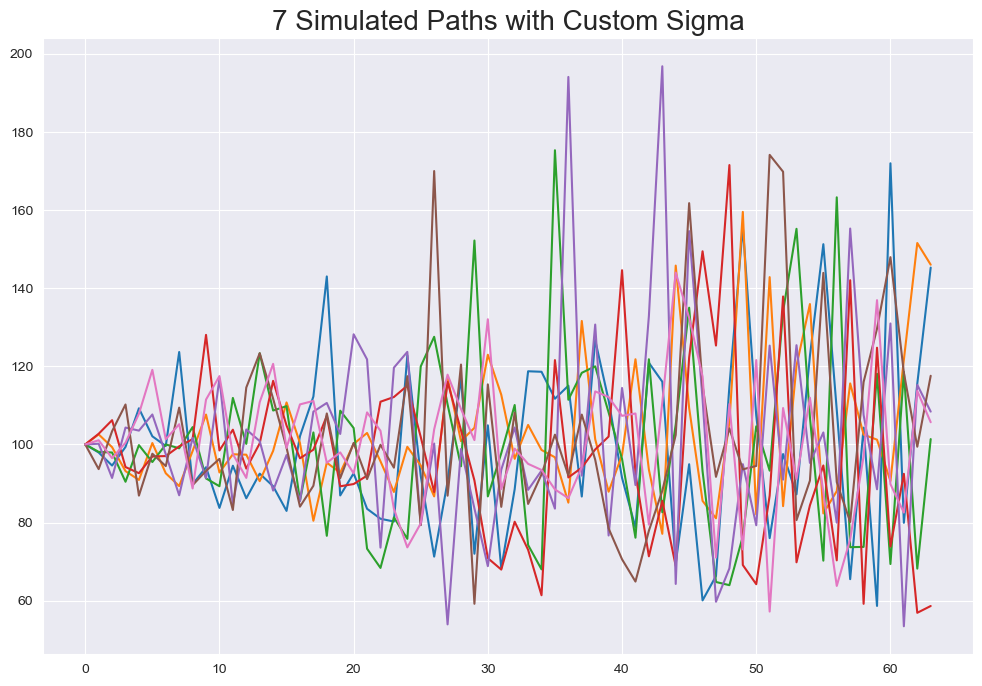

In [72]:
#Variation 3: increase kappa for less reversion to the mean
simulated_paths = stock_path_custom_sigma_owen(S0, t, r, mu, n_paths, n_steps, v0 = 0.08, kappa=5, theta=0.1, xi=.5, rho=-.65)


plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)


plt.show()

Larger peaks.

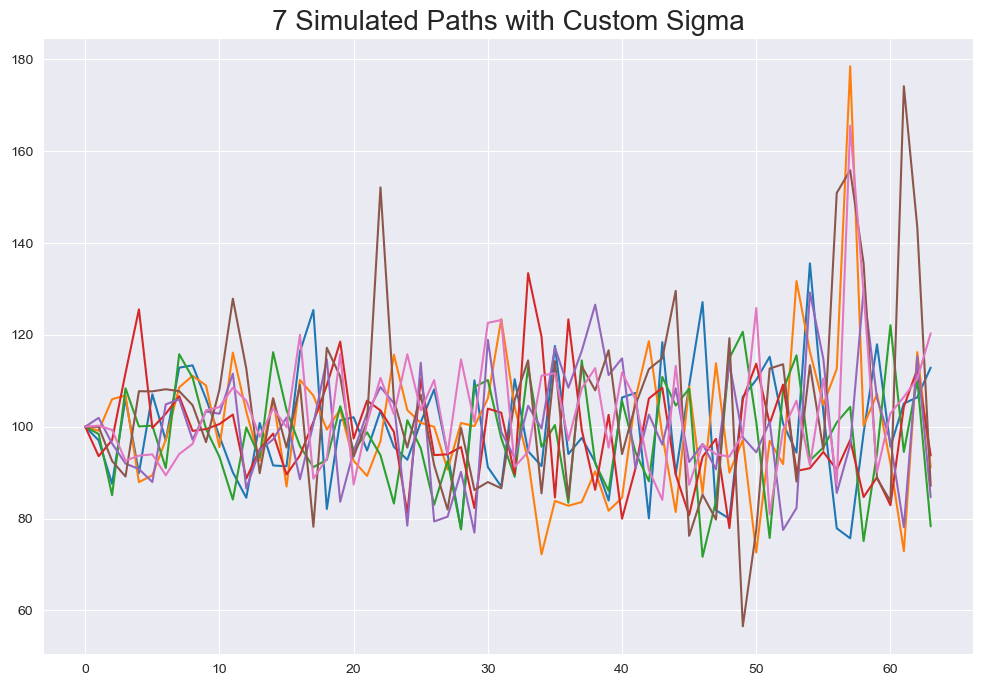

In [73]:
#Variation 4: assume the long run variance is lower
simulated_paths = stock_path_custom_sigma_owen(S0, t, r, mu, n_paths, n_steps, v0 = 0.08, kappa=3, theta=0.04, xi=.5, rho=-.65)


plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)


plt.show()

Packed in more tightly.

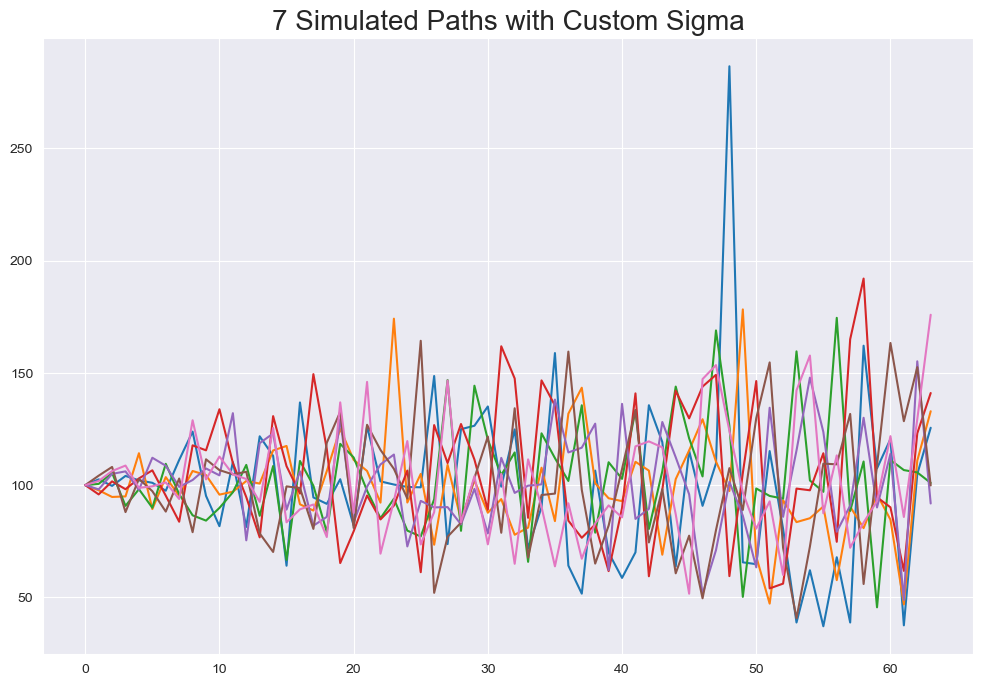

In [74]:
#Variation 5: assume the long run variance is higher
simulated_paths = stock_path_custom_sigma_owen(S0, t, r, mu, n_paths, n_steps, v0 = 0.08, kappa=3, theta=0.25, xi=.5, rho=-.65)


plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)


plt.show()

Packed in less tightly.

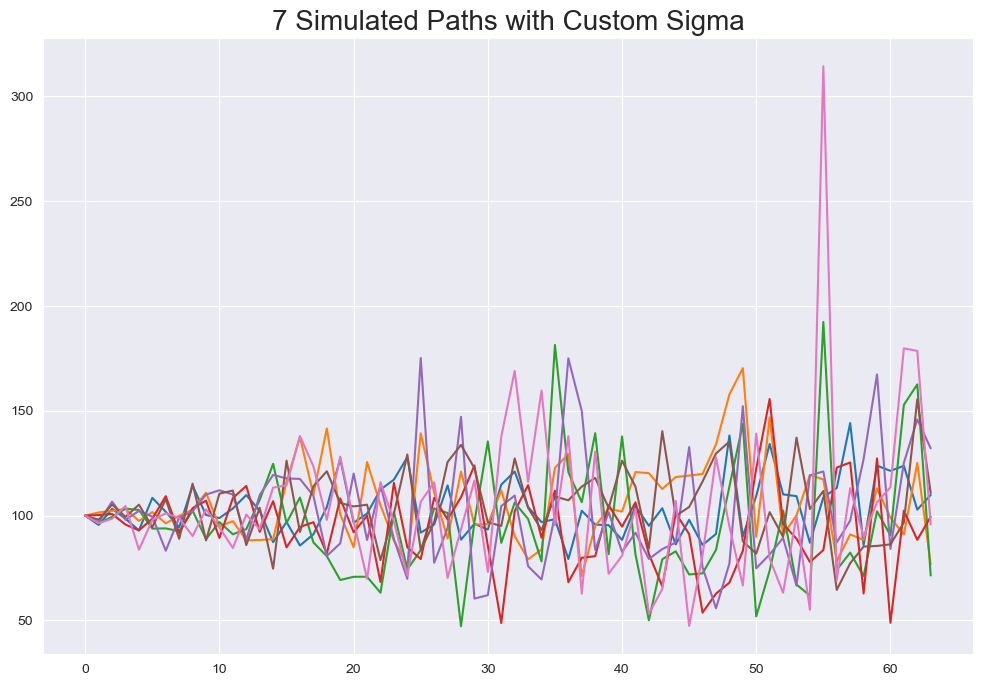

In [75]:
#Variation 6: assume the xi (volatility of volatility) is at max value
simulated_paths = stock_path_custom_sigma_owen(S0, t, r, mu, n_paths, n_steps, v0 = 0.08, kappa=3, theta=0.1, xi=1, rho=-.65)


plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)


plt.show()

Greater number of outliers.

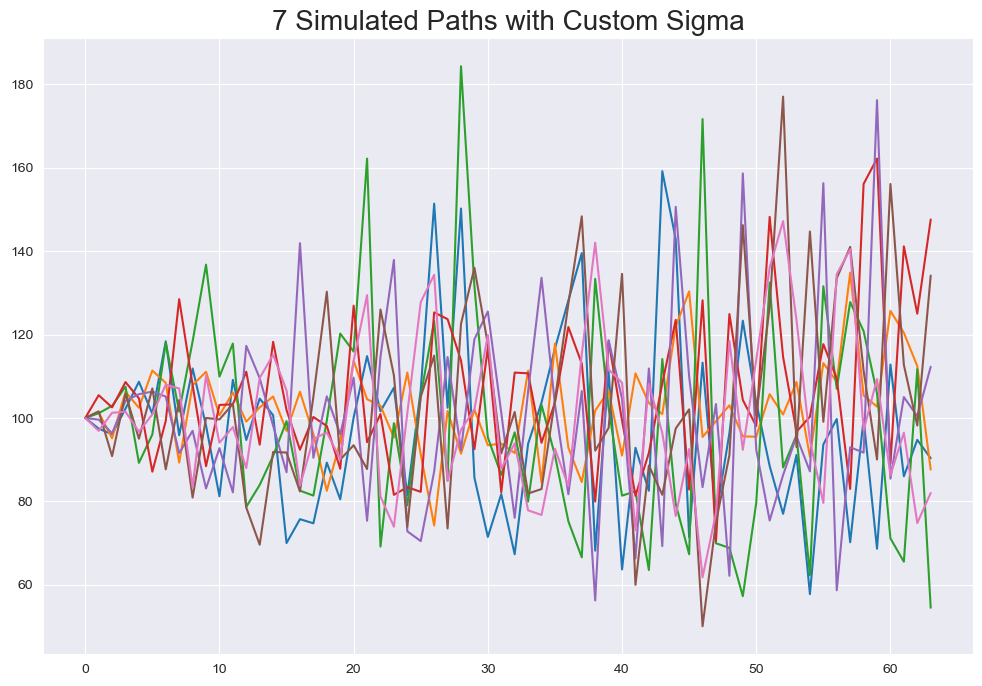

In [76]:
#Variation 7: lower the random noise correlation
simulated_paths = stock_path_custom_sigma_owen(S0, t, r, mu, n_paths, n_steps, v0 = 0.08, kappa=3, theta=0.1, xi=.5, rho=-.44)


plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)


plt.show()

This is officially "all over the place."

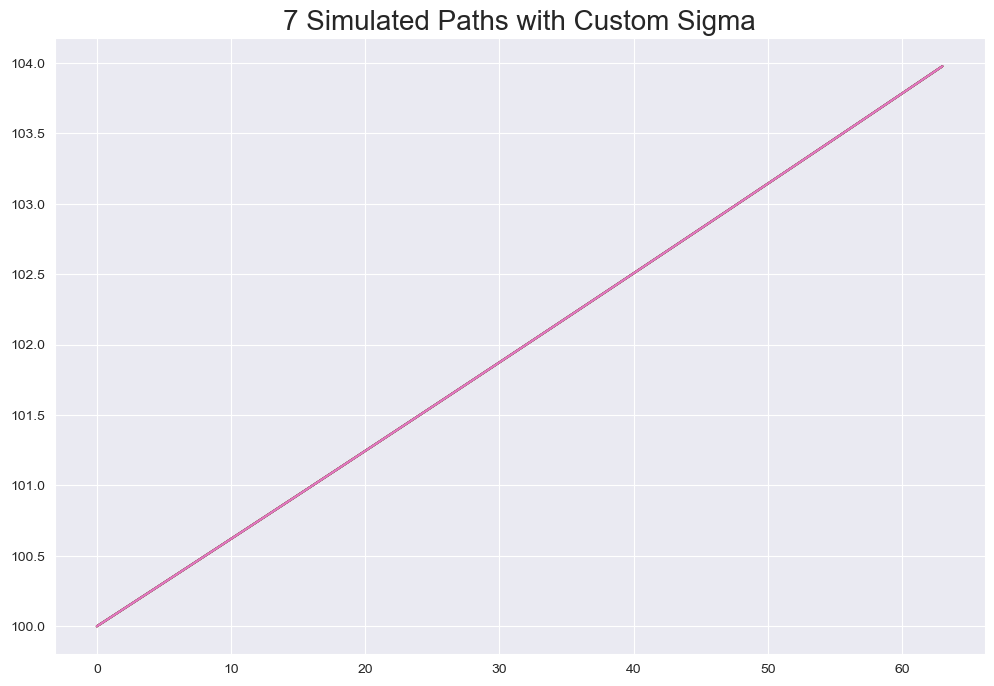

In [77]:
#Variation 8: remain with Black-Shoals parameters.
simulated_paths = stock_path_custom_sigma_owen(S0, t, r, mu, n_paths, n_steps, v0 = 0, kappa=0, theta=0.1, xi=0, rho=-0.5)


plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)


plt.show()

# boring

Boring. Now let $v_0 = 0.08$ but don't change anything else.

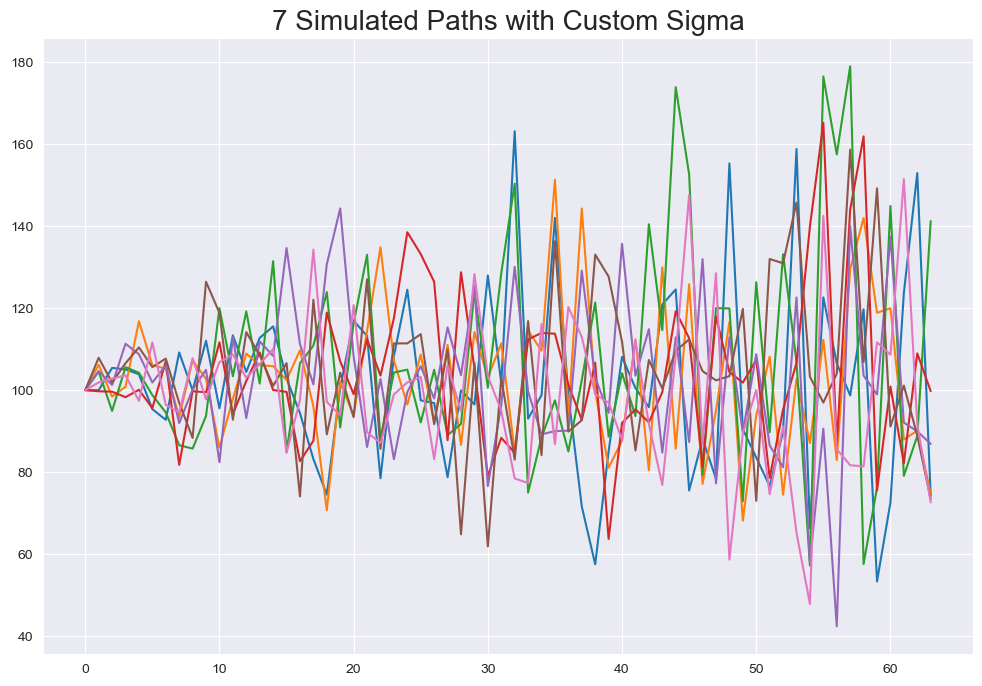

In [78]:
#Variation 9: remain with Black-Shoals parameters.
simulated_paths = stock_path_custom_sigma_owen(S0, t, r, mu, n_paths, n_steps, v0 = 0.08, kappa=0, theta=0.1, xi=0, rho=-0.5)


plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)


plt.show()

# boring

This still resembles the real stock paths from the first example, but is exceptionally random. This affirms that the Heston model and $\sigma$-hedging provide more realistic stock paths.